# Integration of pygcc with EQ3/6

#### Import pygcc, EQ3/6 environment and other modules

All files used in this tutorial can be downloaded from https://bitbucket.org/Tutolo-RTG/pygcc/src/master/docs/

Download [output_reader](https://bitbucket.org/Tutolo-RTG/pygcc/src/master/docs/output_reader.py) into your working directory

In [1]:
import os, subprocess, re, numpy as np, pandas as pd, sys
import shutil
from pygcc.pygcc_utils import *
import pygcc
print(pygcc.__version__)
from output_reader import read_eq36output

1.0.6


Set current working directory and EQ3/6 working directory. This is because EQ3/6 can only run from its working directory

In [2]:
eq_dir = "C:\Eq3_6v8.0a\work_db"
if os.path.exists(eq_dir) == False:
    os.makedirs(os.path.join(eq_dir))
    
current_dir = os.getcwd()
output_folder = 'Vent_spec'
if os.path.exists(os.path.join(os.getcwd(), output_folder)) == False:
    os.makedirs(os.path.join(os.getcwd(), output_folder))

In [3]:
# function to copy file between source and destination directory
def copyfile(source_dir, destination_dir):
    # Source path
    source = source_dir

    # Destination path
    destination = destination_dir
  
    try:
        shutil.copy(source, destination)
        print("File copied successfully.")

    # If source and destination are same
    except shutil.SameFileError:
        print("Same files are in the Source and destination path.")

    # If there is any permission issue
    except PermissionError:
        print("Permission denied.")

    # For other errors
    except:
        print("Error occurred while copying file.")

#### Load filtered vent fluid data

In [4]:
filename = './MARHYS_DB_2_0_filter.csv'
df = pd.read_csv(filename)
i = 2
df.loc[i, :]

Sample-ID                       EPR 21°N-OBS-1985
Geol_setting         Mid-oceanic spreading center
Rock_type_primary                          Basalt
Depth                                        2500
Temp                                          340
pH                                            3.4
XH2S                                          7.6
Cl                                          500.0
Na                                          439.0
Fe                                           1530
Mn                                           1024
H2                                           0.01
K                                            23.5
Ca                                           15.6
Si                                           17.6
Cu                                            0.0
Press                                  251.945325
Name: 2, dtype: object

Here we will work with EPR 21 N sample to run speciation and warm up the fluid from 25 °C to 340 °C
#### Generate the database for the vent fluid with pygcc and run the database through EQ3/6 preprocessing
We initialize the inputs and generate the database

In [5]:
P = np.round(df.loc[i,:].Press)
Temp = df.loc[i,:].Temp;       npH = df.loc[i,:].pH
# multiplication was done to convert the concentrations from mmol/kg and umol/kg to mol/kg
nCl = df.loc[i,:].Cl*1e-3;     nNa = df.loc[i,:].Na*1e-3
nH2S = df.loc[i,:].XH2S*1e-3;  nFe = df.loc[i,:].Fe*1e-6
nMn = df.loc[i,:].Mn*1e-6;     nH2 = df.loc[i,:].H2*1e-6
nK = df.loc[i,:].K*1e-3;       nCu = df.loc[i,:].Cu*1e-6;    
nCa = df.loc[i,:].Ca*1e-3;     nSi = df.loc[i,:].Si*1e-3

write_database(T = [20, Temp], P = P, solid_solution = True, objdb = './data0', 
               clay_thermo = 'Yes', dataset = 'eq36',  sourcedb =  './database/data0.geo') #

D:\ProgramData\Anaconda3\lib\site-packages\pygcc\pygcc_utils.py:3409: UserWarning: Some temperature and pressure points are out of aqueous species HKF eqns regions of applicability, hence, density extrapolation has been applied
  warnings.warn('Some temperature and pressure points are out of aqueous species HKF eqns regions of applicability, hence, density extrapolation has been applied')


Success, your new EQ3/6 database is ready for download


Copy the generated database to the EQ3/6 work environment specified above and run through eqpt for preprocessing

In [6]:
copyfile(current_dir + '/output/EQ36/data0.geo', eq_dir + '/data0.pym')

Error occurred while copying file.


In [7]:
# change the working directory to EQ3/6 work environment
os.chdir(eq_dir)
# load EQ3/6 environment
os.environ["EQ36CO"] = "C:\Eq3_6v8.0a\Bin"
os.environ["EQ36DA"] = eq_dir

In [8]:
# check the "eqptout.txt" for the output of the database preprocessing
f = open(current_dir + "/%s/eqptout.txt" % output_folder, "w")
subprocess.run([r'C:/Eq3_6v8.0a/bin/runeqpt', 'pym'], stdout = f)
f.close()

Replace species and concentration in an existing eq3 file

In [9]:
# change the working directory back to current work environment to do some calculations and build input files
os.chdir(current_dir)

In [10]:
# Switch basis between HS- and SO4--
lst = ['|Special Basis Switches (for model definition only)       | (nsbswt)           |\n',  
       '|------------------------------------------------------------------------------|\n',
       '|Replace |SO4--                                           | (usbsw(1,n))       |\n',
       '|   with |HS-                                             | (usbsw(2,n))       |\n',
       '|------------------------------------------------------------------------------|\n']
lst

['|Special Basis Switches (for model definition only)       | (nsbswt)           |\n',
 '|------------------------------------------------------------------------------|\n',
 '|Replace |SO4--                                           | (usbsw(1,n))       |\n',
 '|   with |HS-                                             | (usbsw(2,n))       |\n',
 '|------------------------------------------------------------------------------|\n']

In [11]:
# Set H2(aq) as the redox constraint
lst2 = ['|Default redox constraint (irdxc3):                                            |\n',
        '|  [ ] (-3) Use O2(g) line in the aqueous basis species block                  |\n',
        '|  [ ] (-2) pe (pe units)      | 0.00000E+00| (pei)                            |\n',
        '|  [ ] (-1) Eh (volts)         | 5.00000E-01| (ehi)                            |\n',
        '|  [ ] ( 0) Log fO2 (log bars) |-7.00000E-01| (fo2lgi)                         |\n',
        '|  [x] ( 1) Couple (aux. sp.)  |H2(aq)                  | (uredox)             |\n',
        '|------------------------------------------------------------------------------|\n']
lst2

['|Default redox constraint (irdxc3):                                            |\n',
 '|  [ ] (-3) Use O2(g) line in the aqueous basis species block                  |\n',
 '|  [ ] (-2) pe (pe units)      | 0.00000E+00| (pei)                            |\n',
 '|  [ ] (-1) Eh (volts)         | 5.00000E-01| (ehi)                            |\n',
 '|  [ ] ( 0) Log fO2 (log bars) |-7.00000E-01| (fo2lgi)                         |\n',
 '|  [x] ( 1) Couple (aux. sp.)  |H2(aq)                  | (uredox)             |\n',
 '|------------------------------------------------------------------------------|\n']

In [12]:
ion_lst = ['Fe++', 'Na+', 'H+', 'Cl-', 'HS-', 'Mn++', 'K+', 'Ca++', 'SiO2(aq)', 'Cu++', 'H2(aq)'] # , 'H2S(aq)'
conc_lst = [nFe, nNa, npH, nCl, nH2S, nMn, nK, nCa, nSi, nCu, nH2]

lst3 = ['|Aqueous Basis Species/Constraint Species        |Conc., etc. |Units/Constraint|\n',
        '| (uspeci(n)/ucospi(n))                          | (covali(n))|(ujf3(jflgi(n)))|\n',
        '|------------------------------------------------------------------------------|\n']
for i, j in zip(ion_lst, conc_lst):
    units = 'Molality        ' if i != 'H+' else 'pH              '
    lst3.append('|%-10s                                      | %.5e|%s|\n' % (i, j, units))
lst3.append('|------------------------------------------------------------------------------|\n')
lst3

['|Aqueous Basis Species/Constraint Species        |Conc., etc. |Units/Constraint|\n',
 '| (uspeci(n)/ucospi(n))                          | (covali(n))|(ujf3(jflgi(n)))|\n',
 '|------------------------------------------------------------------------------|\n',
 '|Fe++                                            | 1.53000e-03|Molality        |\n',
 '|Na+                                             | 4.39000e-01|Molality        |\n',
 '|H+                                              | 3.40000e+00|pH              |\n',
 '|Cl-                                             | 5.00000e-01|Molality        |\n',
 '|HS-                                             | 7.60000e-03|Molality        |\n',
 '|Mn++                                            | 1.02400e-03|Molality        |\n',
 '|K+                                              | 2.35000e-02|Molality        |\n',
 '|Ca++                                            | 1.56000e-02|Molality        |\n',
 '|SiO2(aq)                                

In [13]:
# open an existing sample file and a new in put file
fin = open("swmaj_ex.3i", "r")
fout = open("./%s/swmaj.3i" % output_folder, "w")

# read and paste line by line until the beginning of the "Special Basis Switches" block
for i in range(1000):#
    s = fin.readline()
    if s.strip('|').startswith("Special Basis Switches"):
        break
    fout.writelines(s)
# paste the new "Special Basis Switches" block
fout.writelines(lst)
# read and skip pasting until the end of the "Special Basis Switches" block
for i in range(1000):#
    s = fin.readline()
    if s.strip('|').startswith("Temperature (C)"):
        break
fout.writelines(s)

# read and paste line by line until the beginning of the "Default redox constraint" block
for i in range(1000):#
    s = fin.readline()
    if s.strip('|').startswith("Default redox constraint"):
        break
    fout.writelines(s)
# paste the new "Special Basis Switches" block
fout.writelines(lst2)
# read and skip pasting until the end of the "Default redox constraint" block and 
# the beginning of the "Aqueous Basis Species" block
for i in range(1000):#
    s = fin.readline()
    if s.strip('|').startswith("Aqueous Basis Species/Constraint Species"):
        break

# paste the new "Aqueous Basis Species" block
fout.writelines(lst3)
# read and skip pasting until the end of the "Aqueous Basis Species" block
for i in range(1000):#
    s = fin.readline()
    if s.strip('* ').startswith("Valid jflag strings"):
        break
fout.writelines(s)

# read and paste the rest of the files
for i in range(1000):#
    s = fin.readline()
    fout.writelines(s)

fout.close()
fin.close()

Copy the new eq3 input file to the EQ3/6 work environment and run eq3

In [14]:
copyfile(current_dir + '/%s/swmaj.3i' % output_folder, eq_dir + '/swmaj.3i')

File copied successfully.


In [15]:
# change the working directory to EQ3/6 work environment
os.chdir(eq_dir)

# check the "eq3out.txt" for the eq3 run details
f = open(current_dir + "/%s/eq3out.txt" % output_folder, "w")
subprocess.run([r'C:\Eq3_6v8.0a/bin/runeq3', 'pym',  'swmaj.3i'], stdout = f)
f.close()

Generate a new eq6 file to run speciation and warm up temperature

In [16]:
# change the working directory back to current work environment to build input files
os.chdir(current_dir)

In [17]:
Descript = 'Heat ventfluid from 25C to %sC' % Temp
# open an existing sample file, a new input file and the copied eq3 output file
fin = open("swmaj_ex.6i", "r")
fout = open("./%s/swmaj.6i" % output_folder, "w")
f3p = open(eq_dir + "/swmaj.3p", "r")
# read and paste line by line until the beginning of the first "Linear tracking in Xi" in the "Temperature option" block
for i in range(1000):#
    s = fin.readline()
    if s.strip('|  ').startswith("[x] ( 1) Linear tracking in Xi"):
        break
    if s.strip('|').startswith('EQ6 input file name'):
        line = '%s= %-11s                                             |\n' % (s.split('=')[0], 
                                                                              'swmaj.6i')
        fout.writelines(line)
    elif s.strip('|').startswith('Description'):
        line = '%s= %-45s                    |\n' % (s.split('=')[0], Descript)
        fout.writelines(line)
    else:
        fout.writelines(s)

#create the new "Linear tracking in Xi" subblock and paste the new subblock
derivative = (Temp - 25)/1
lst = ['|  [x] ( 1) Linear tracking in Xi:                                             |\n',
       '|             Base Value (C)    | 2.50000E+01| (tempcb)                        |\n',
       '|             Derivative        | %.5e| (ttk(1))                        |\n' % derivative]
fout.writelines(lst)

# read and skip pasting until the end of the "Linear tracking in Xi" subblock
for i in range(1000):#
    s = fin.readline()
    if s.strip('|').lstrip().startswith("Derivative"):
        break

# read and paste line by line until the beginning of the "eq3 output" input
for i in range(10000):#
    s = fin.readline()
    if s.strip('* ').startswith("Start of the bottom half of the INPUT file"):
        break
    fout.writelines(s)

# paste the new eq3 output
for i in range(1000):#
    s = f3p.readline()
    fout.writelines(s)
fout.close()
fin.close()
f3p.close()

Copy the new eq6 input file to the EQ3/6 work environment and run eq6

In [18]:
copyfile(current_dir + '/%s/swmaj.6i' % output_folder, eq_dir + '/swmaj.6i')

File copied successfully.


In [19]:
# change the working directory to EQ3/6 work environment
os.chdir(eq_dir)

# check the "eq6out.txt" for the eq6 run details
f = open(current_dir + "/%s/eq6out.txt" % output_folder, "w")
subprocess.run([r'C:\Eq3_6v8.0a/bin/runeq6', 'pym', 'swmaj.6i'], stdout = f)
f.close()

#### Results processing

In [20]:
data = {}
rerun = []
path = eq_dir + '/'
files = os.listdir(path)
for i, f in enumerate(files):
    if f.endswith('.6o'): 
        size = os.path.getsize(path + f)/(1024) #size in KB
        if size > 2:
            data[f[:-3]] = read_eq36output(path + f)
        else:
            rerun.append(f)
print(rerun)

[]


In [21]:
data_df = data['swmaj']
# data_df

In [22]:
data_df.columns

Index(['Xi', 'pH', 'Temperature_C', 'Pressure_bars', 'Water_mass_g',
       'Rock_mass_g', 'M_Ca++', 'M_CaCl+', 'M_CaCl2(aq)', 'M_CaHSiO3+',
       'M_CaOH+', 'M_CaSO4(aq)', 'M_Cl-', 'M_Cu+', 'M_CuCl(aq)', 'M_CuCl2-',
       'M_CuCl3--', 'M_Fe++', 'M_Fe+++', 'M_FeCl+', 'M_FeCl++', 'M_FeCl2(aq)',
       'M_FeO(aq)', 'M_FeO+', 'M_FeO2-', 'M_FeOH+', 'M_FeOH++', 'M_H+',
       'M_H2(aq)', 'M_H2S(aq)', 'M_H2S2O3(aq)', 'M_HFeO2(aq)', 'M_HFeO2-',
       'M_HS-', 'M_HS2O3-', 'M_HSO3-', 'M_HSO4-', 'M_HSiO3-', 'M_K+',
       'M_KCl(aq)', 'M_KHSO4(aq)', 'M_KOH(aq)', 'M_KSO4-', 'M_Mn++', 'M_MnCl+',
       'M_MnO(aq)', 'M_MnOH+', 'M_MnSO4(aq)', 'M_Na+', 'M_NaCl(aq)',
       'M_NaHSiO3(aq)', 'M_NaOH(aq)', 'M_NaSO4-', 'M_OH-', 'M_S2--',
       'M_S2O3--', 'M_S3--', 'M_S4--', 'M_S5--', 'M_SO2(aq)', 'M_SO4--',
       'M_SiO2(aq)', 'TotM_Ca++', 'TotM_Cl-', 'TotM_Cu++', 'TotM_Fe++',
       'TotM_H+', 'TotM_H2O', 'TotM_HS-', 'TotM_K+', 'TotM_Mn++', 'TotM_Na+',
       'TotM_O2(g)', 'TotM_SiO2(aq)', 'SI_Ala

Plot pyrite saturation with Temperature

Text(0, 0.5, '$Log_{10}$(Q/K)$_{Pyrite}$')

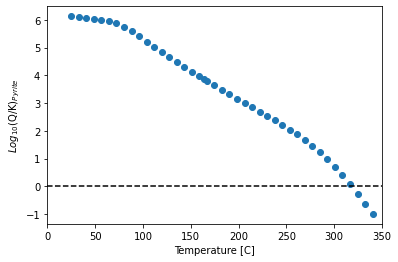

In [23]:
import matplotlib.pyplot as plt
y = data_df.SI_Pyrite
x = data_df.Temperature_C
plt.figure()
plt.scatter(x, y)
plt.plot([0, 350], [0, 0], 'k--')
plt.xlim([0, 350])
plt.xlabel('Temperature [C]')
plt.ylabel('$Log_{10}$(Q/K)$_{Pyrite}$')

plot pH with Temperature

Text(0, 0.5, 'pH')

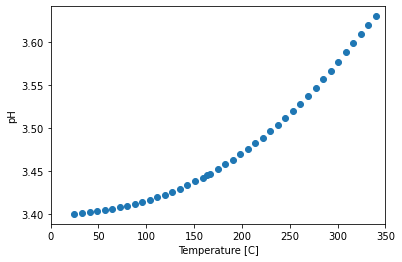

In [24]:
y = data_df.pH
x = data_df.Temperature_C
plt.figure()
sc = plt.scatter(x, y)
plt.xlim([0, 350])
plt.xlabel('Temperature [C]')
plt.ylabel('pH')